In [1]:
import sys
import os
import yfinance as yf

import pandas as pd

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

root_path = os.path.abspath("..")   # go up one directory
sys.path.append(root_path)

from Project.param import *


In [2]:
data = yf.download(TICKER, start=START_DATE, end=END_DATE)
data

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.418382,6.433078,6.369497,6.400987,493729600
2010-01-05,6.429482,6.465771,6.395592,6.436080,601904800
2010-01-06,6.327210,6.454972,6.320612,6.429479,552160000
2010-01-07,6.315514,6.358102,6.269628,6.350604,477131200
2010-01-08,6.357501,6.358101,6.269928,6.307116,447610800
...,...,...,...,...,...
2020-11-25,112.949677,113.650563,112.112507,112.482424,76499200
2020-11-27,113.494789,114.370898,113.134617,113.475323,46691300


In [18]:
df = data.copy()  # your original yfinance data

# 1. Reset index so Date becomes a column
df = df.reset_index()

# 2. Flatten MultiIndex columns (e.g., ('Price','Close') → 'Price_Close')
df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]

# 3. Optionally rename columns to clean names like yfinance default
df = df.rename(columns={
    "Date": "Date",
    "Price_Open": "Open",
    "Price_High": "High",
    "Price_Low": "Low",
    "Price_Close": "Close",
    "Price_Volume": "Volume",
    "Price_Adj Close": "Adj Close",
})

df

,Date,Close,High,Low,Open,Volume
0,2010-01-04,6.418382,6.433078,6.369497,6.400987,493729600
1,2010-01-05,6.429482,6.465771,6.395592,6.436080,601904800
2,2010-01-06,6.327210,6.454972,6.320612,6.429479,552160000
3,2010-01-07,6.315514,6.358102,6.269628,6.350604,477131200
4,2010-01-08,6.357501,6.358101,6.269928,6.307116,447610800
...,...,...,...,...,...,...
2744,2020-11-25,112.949677,113.650563,112.112507,112.482424,76499200
2745,2020-11-27,113.494789,114.370898,113.134617,113.475323,46691300
2746,2020-11-30,115.889503,117.758530,113.708965,113.864721,169410200
2747,2020-12-01,119.462074,120.192164,116.824019,117.797472,127728200


In [ ]:
train_data = df[:length_train].iloc[:,:2]
train_data['Date'] = pd.to_datetime(train_data['Date'])  # converting to date time object
train_data

,Date,Close
0,2010-01-04,6.418382
1,2010-01-05,6.429482
2,2010-01-06,6.327210
3,2010-01-07,6.315514
4,2010-01-08,6.357501
...,...,...
1919,2017-08-17,36.837105
1920,2017-08-18,36.753098
1921,2017-08-21,36.685425
1922,2017-08-22,37.285137


In [ ]:
length_data = len(data)     # rows that data has
split_ratio = 0.7           # %70 train + %30 validation
length_train = round(length_data * split_ratio)
length_validation = length_data - length_train
print("Data length :", length_data)
print("Train data length :", length_train)
print("Validation data lenth :", length_validation)

Data length : 2749
Train data length : 1924
Validation data lenth : 825


In [22]:
validation_data = df[length_train:].iloc[:,:2]
validation_data['Date'] = pd.to_datetime(validation_data['Date'])  # converting to date time object
validation_data

,Date,Close
1924,2017-08-24,37.166130
1925,2017-08-25,37.303799
1926,2017-08-28,37.679504
1927,2017-08-29,38.015541
1928,2017-08-30,38.118210
...,...,...
2744,2020-11-25,112.949677
2745,2020-11-27,113.494789
2746,2020-11-30,115.889503
2747,2020-12-01,119.462074


In [24]:
dataset_train = train_data.Close.values
dataset_train.shape

(1924,)

In [25]:
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(1924, 1)

In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
dataset_train_scaled = scaler.fit_transform(dataset_train)

dataset_train_scaled.shape

(1924, 1)

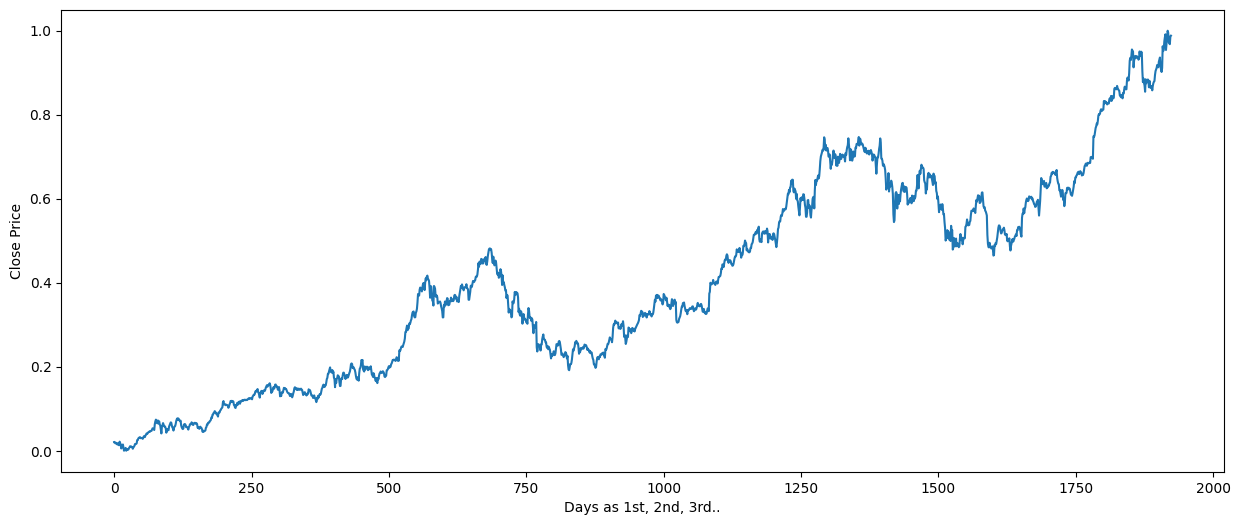

In [28]:
plt.subplots(figsize = (15,6))
plt.plot(dataset_train_scaled)
plt.xlabel("Days as 1st, 2nd, 3rd..")
plt.ylabel("Close Price")
plt.show()

In [ ]:
X_train = []
y_train = []

time_step = 50

for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])

# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)

In [30]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Shape of X_train after reshape :",X_train.shape)
print("Shape of y_train after reshape :",y_train.shape)

Shape of X_train after reshape : (1874, 50, 1)
Shape of y_train after reshape : (1874, 1)


In [31]:
X_train[0]


array([[2.06135002e-02],
       [2.09609116e-02],
       [1.77599157e-02],
       [1.73938488e-02],
       [1.87079913e-02],
       [1.69526522e-02],
       [1.47092090e-02],
       [1.74595462e-02],
       [1.63142887e-02],
       [1.30289995e-02],
       [2.15803807e-02],
       [1.84733342e-02],
       [1.50377558e-02],
       [5.35047480e-03],
       [1.03443896e-02],
       [1.30383572e-02],
       [1.48593489e-02],
       [6.79602712e-03],
       [9.38747866e-06],
       [2.51566519e-03],
       [3.57642043e-03],
       [6.73976194e-03],
       [0.00000000e+00],
       [3.20095113e-03],
       [1.94307376e-03],
       [3.88622215e-03],
       [2.88176193e-03],
       [6.21415269e-03],
       [7.81927722e-03],
       [1.06541018e-02],
       [9.85622576e-03],
       [1.02128455e-02],
       [9.03012764e-03],
       [7.85678236e-03],
       [4.70281339e-03],
       [8.08214154e-03],
       [9.33998906e-03],
       [1.17992995e-02],
       [1.59013441e-02],
       [1.57699194e-02],


In [32]:
y_train[0]

array([0.03010367])

In [ ]:
# importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

# initializing the RNN
regressor = Sequential()

# adding first RNN layer and dropout regulatization
regressor.add(
    SimpleRNN(units = 50,
              activation = "tanh",
              return_sequences = True,
              input_shape = (X_train.shape[1],1))
             )

regressor.add(
    Dropout(0.2)
             )


# adding second RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50,
              activation = "tanh",
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50,
              activation = "tanh",
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding fourth RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50)
             )

regressor.add(
    Dropout(0.2)
             )

# adding the output layer
regressor.add(Dense(units = 1))

# compiling RNN
regressor.compile(
    optimizer = "adam",
    loss = "mean_squared_error",
    metrics = ["accuracy"])

# fitting the RNN
history = regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.0000e+00 - loss: 0.3483
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 5.3362e-04 - loss: 0.2360
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 5.3362e-04 - loss: 0.1596
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 5.3362e-04 - loss: 0.1102
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 5.3362e-04 - loss: 0.0806
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 5.3362e-04 - loss: 0.0631
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 5.3362e-04 - loss: 0.0487
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0372
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 5.3362e-04 - loss: 0.0314
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 5.3362e-04 - loss: 0.0290
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 5.3362e-04 - loss: 0.0241
Epoch 12/50
59/59 ━

In [34]:
history.history["loss"]

[0.3483212888240814,
 0.2360229790210724,
 0.1596175730228424,
 0.1101672351360321,
 0.08061826229095459,
 0.06312725692987442,
 0.048688918352127075,
 0.03721337020397186,
 0.0313955694437027,
 0.028987620025873184,
 0.02408234216272831,
 0.020772172138094902,
 0.0184492077678442,
 0.016687629744410515,
 0.01597084105014801,
 0.013042564503848553,
 0.01190134510397911,
 0.011181250214576721,
 0.010136409662663937,
 0.009362869895994663,
 0.00839341338723898,
 0.008225671947002411,
 0.007000834681093693,
 0.006166390143334866,
 0.006394258700311184,
 0.005897906608879566,
 0.0061051202937960625,
 0.005348416045308113,
 0.0047584474086761475,
 0.0046235378831624985,
 0.0044726720079779625,
 0.004415501374751329,
 0.004035665187984705,
 0.003921599127352238,
 0.003749488852918148,
 0.003684209194034338,
 0.0033174166455864906,
 0.003118032356724143,
 0.0031382706947624683,
 0.0033837249502539635,
 0.0030784630216658115,
 0.0029950945172458887,
 0.002946281572803855,
 0.002794512780383229

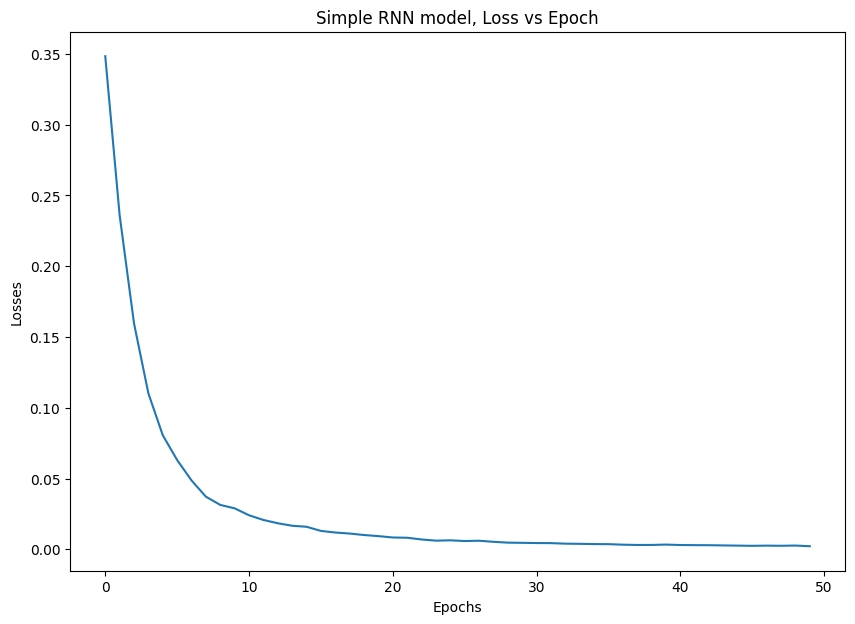

In [35]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

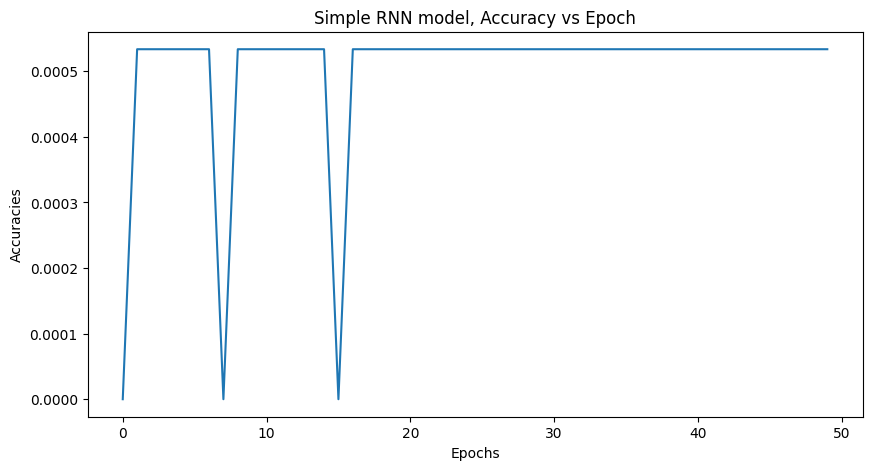

In [36]:
# Plotting Accuracy vs Epochs
plt.figure(figsize =(10,5))
plt.plot(history.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Simple RNN model, Accuracy vs Epoch")
plt.show()

In [37]:
y_pred = regressor.predict(X_train)  # predictions
y_pred = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_pred.shape

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


(1874, 1)

In [38]:
y_train = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train.shape

(1874, 1)

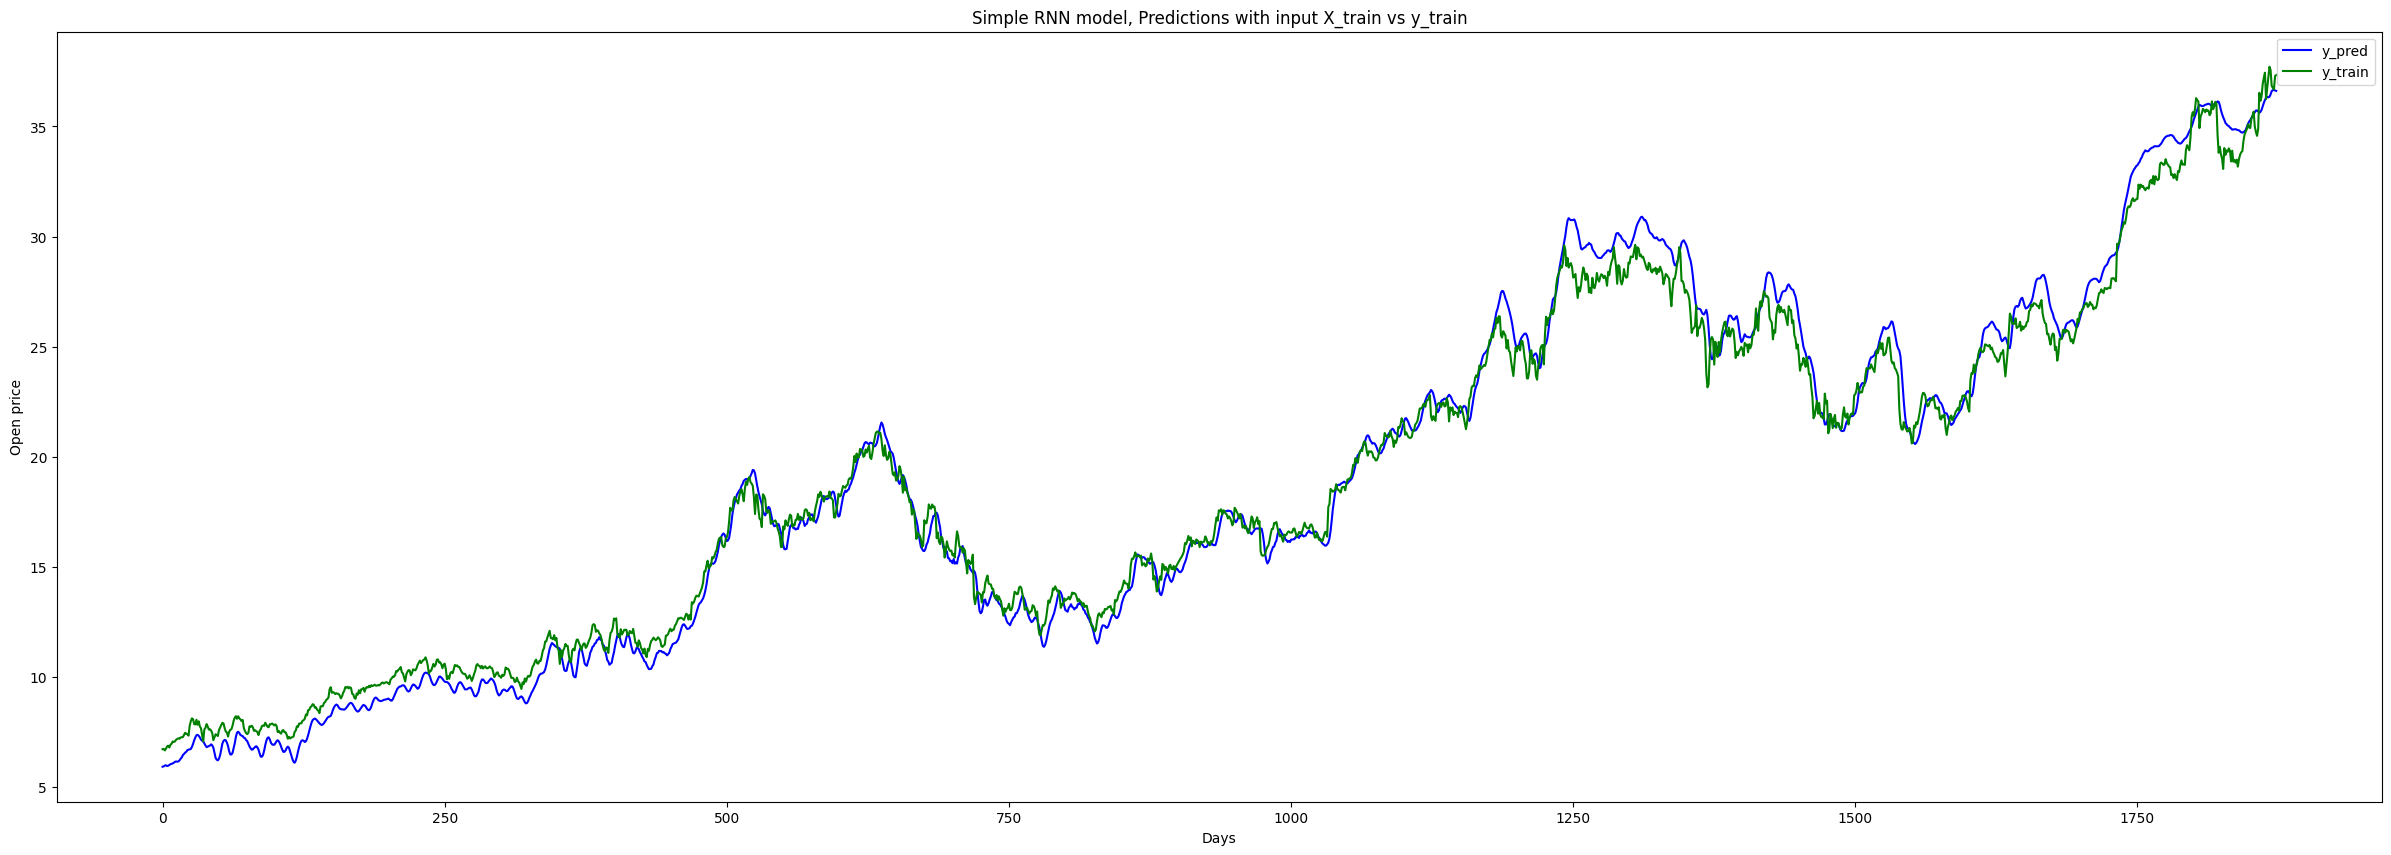

In [39]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

In [42]:
dataset_validation = validation_data.Close.values  # getting "open" column and converting to array
dataset_validation = np.reshape(dataset_validation, (-1,1))  # converting 1D to 2D array
scaled_dataset_validation =  scaler.fit_transform(dataset_validation)  # scaling open values to between 0 and 1
print("Shape of scaled validation dataset :",scaled_dataset_validation.shape)

Shape of scaled validation dataset : (825, 1)


In [43]:
# Creating X_test and y_test
X_test = []
y_test = []

for i in range(time_step, length_validation):
    X_test.append(scaled_dataset_validation[i-time_step:i,0])
    y_test.append(scaled_dataset_validation[i,0])

In [44]:
# Converting to array
X_test, y_test = np.array(X_test), np.array(y_test)

In [45]:
print("Shape of X_test before reshape :",X_test.shape)
print("Shape of y_test before reshape :",y_test.shape)

Shape of X_test before reshape : (775, 50)
Shape of y_test before reshape : (775,)


In [46]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))  # reshape to 3D array
y_test = np.reshape(y_test, (-1,1))  # reshape to 2D array

In [ ]:
# predictions with X_test data
y_pred_of_test = regressor.predict(X_test)
# scaling back from 0-1 to original
y_pred_of_test = scaler.inverse_transform(y_pred_of_test)
print("Shape of y_pred_of_test :",y_pred_of_test.shape)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Shape of y_pred_of_test : (775, 1)


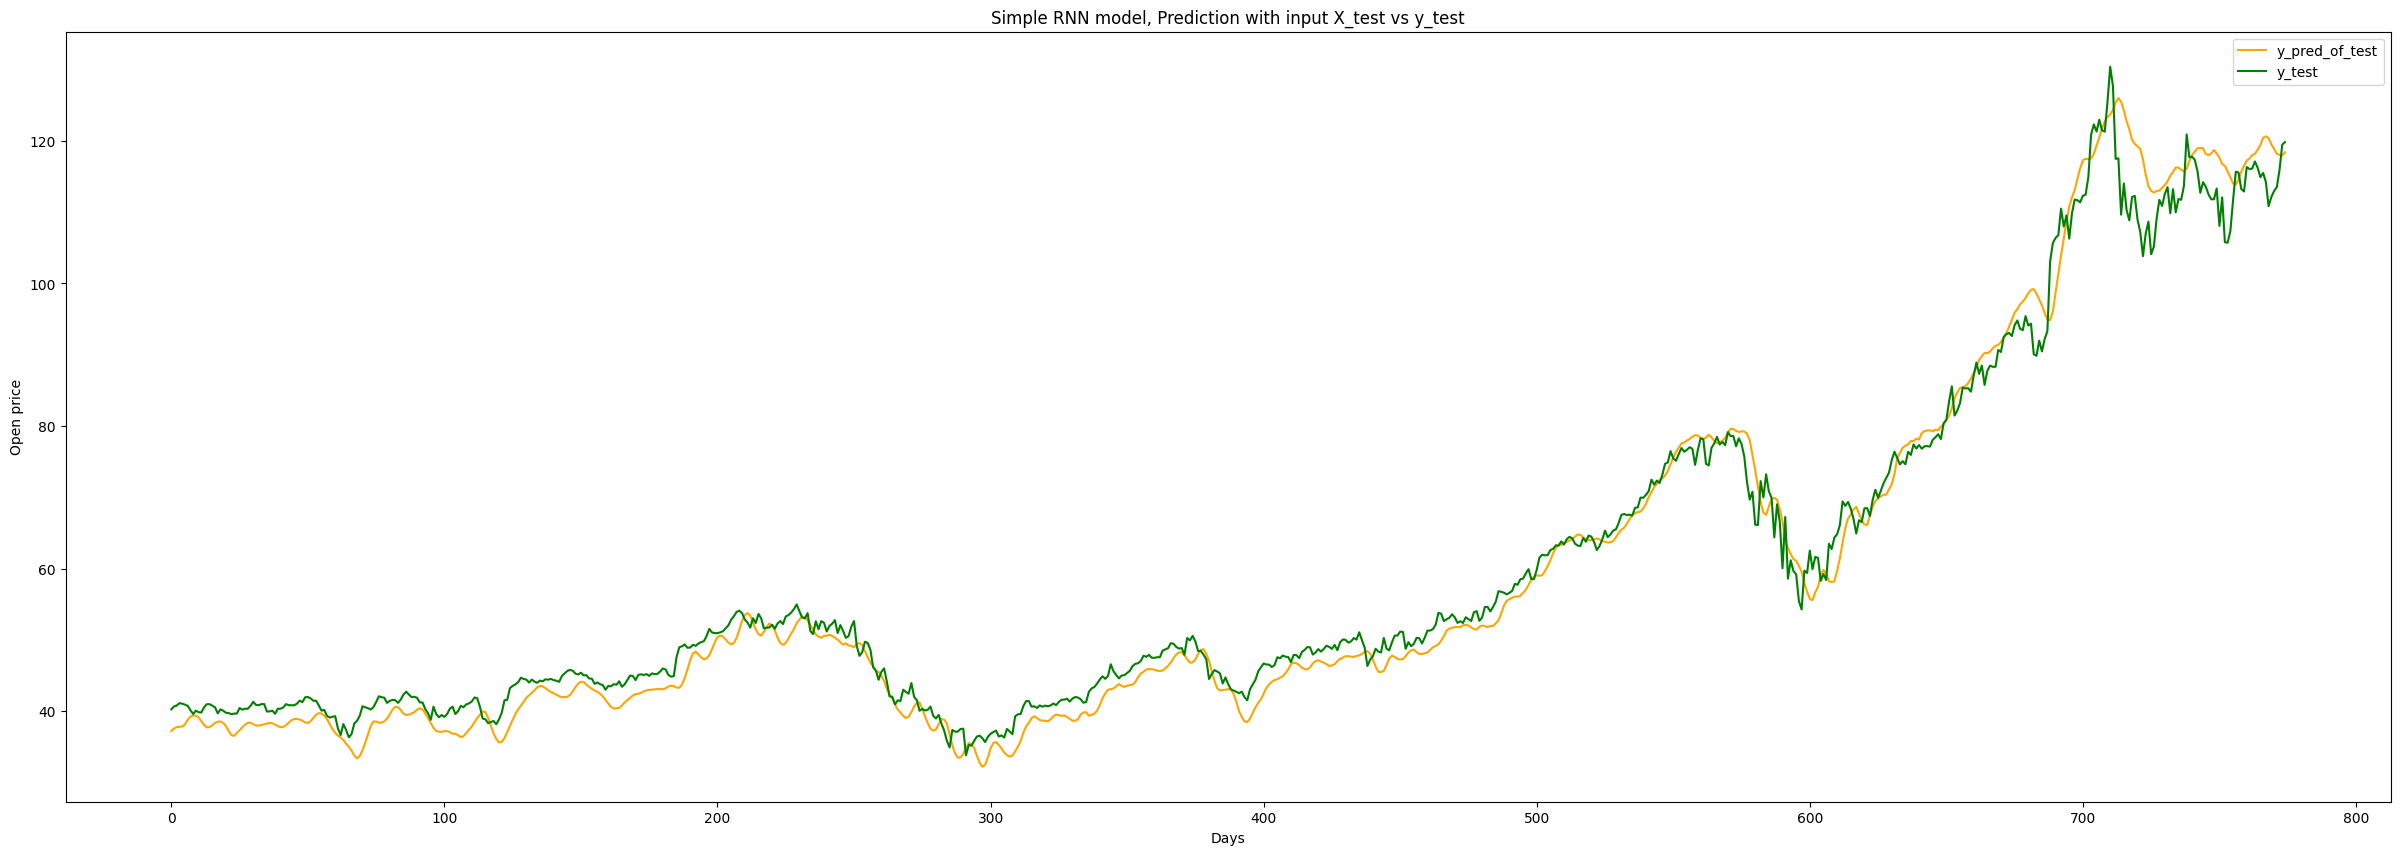

In [48]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred_of_test, label = "y_pred_of_test", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

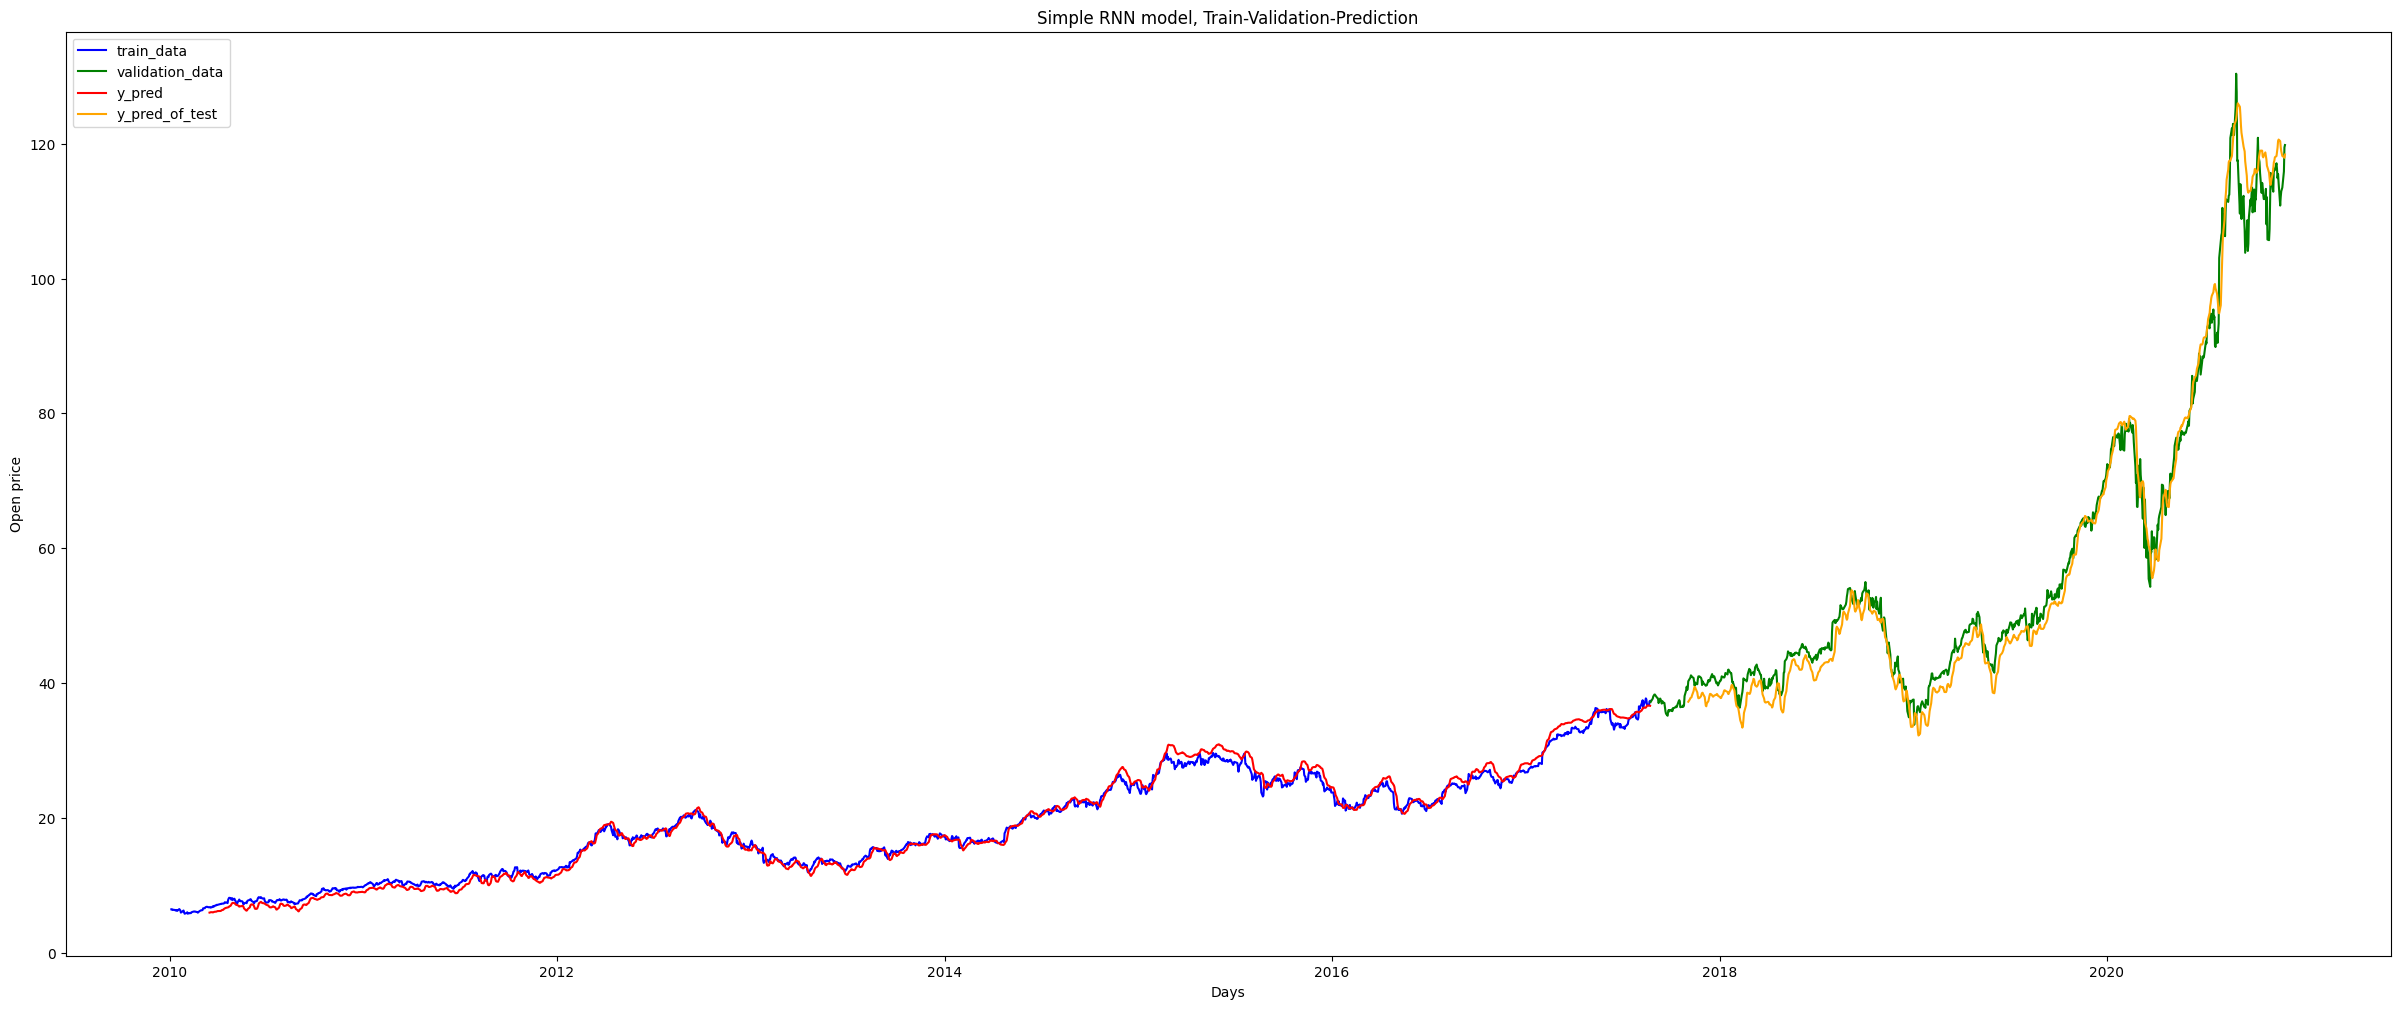

In [51]:
# Visualisation
plt.subplots(figsize =(30,12))
plt.plot(train_data.Date, train_data.Close, label = "train_data", color = "b")
plt.plot(validation_data.Date, validation_data.Close, label = "validation_data", color = "g")
plt.plot(train_data.Date.iloc[time_step:], y_pred, label = "y_pred", color = "r")
plt.plot(validation_data.Date.iloc[time_step:], y_pred_of_test, label = "y_pred_of_test", color = "orange")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Train-Validation-Prediction")
plt.legend()
plt.show()

In [52]:
y_train = scaler.fit_transform(y_train)

In [53]:
from keras.layers import LSTM

model_lstm = Sequential()
model_lstm.add(
    LSTM(64,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
model_lstm.add(
    LSTM(64, return_sequences= False))
model_lstm.add(Dense(32))
model_lstm.add(Dense(1))
model_lstm.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
history2 = model_lstm.fit(X_train, y_train, epochs = 10, batch_size = 10)


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.0011 - loss: 0.0067    
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.0011 - loss: 6.0190e-04
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.0011 - loss: 5.3772e-04    
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.0011 - loss: 5.0042e-04
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.0011 - loss: 4.0785e-04
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.0011 - loss: 4.9054e-04
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.0011 - loss: 3.7687e-04
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.0011 - loss: 3.4981e-04    
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.0011 - loss: 3.0140e-04    
Epoch 10/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.0011 - loss: 2.9990e-04    


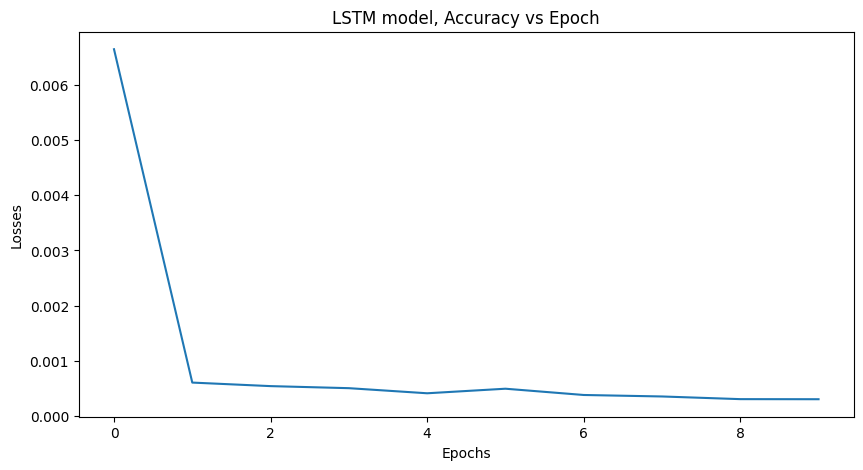

In [54]:
plt.figure(figsize =(10,5))
plt.plot(history2.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, Accuracy vs Epoch")
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


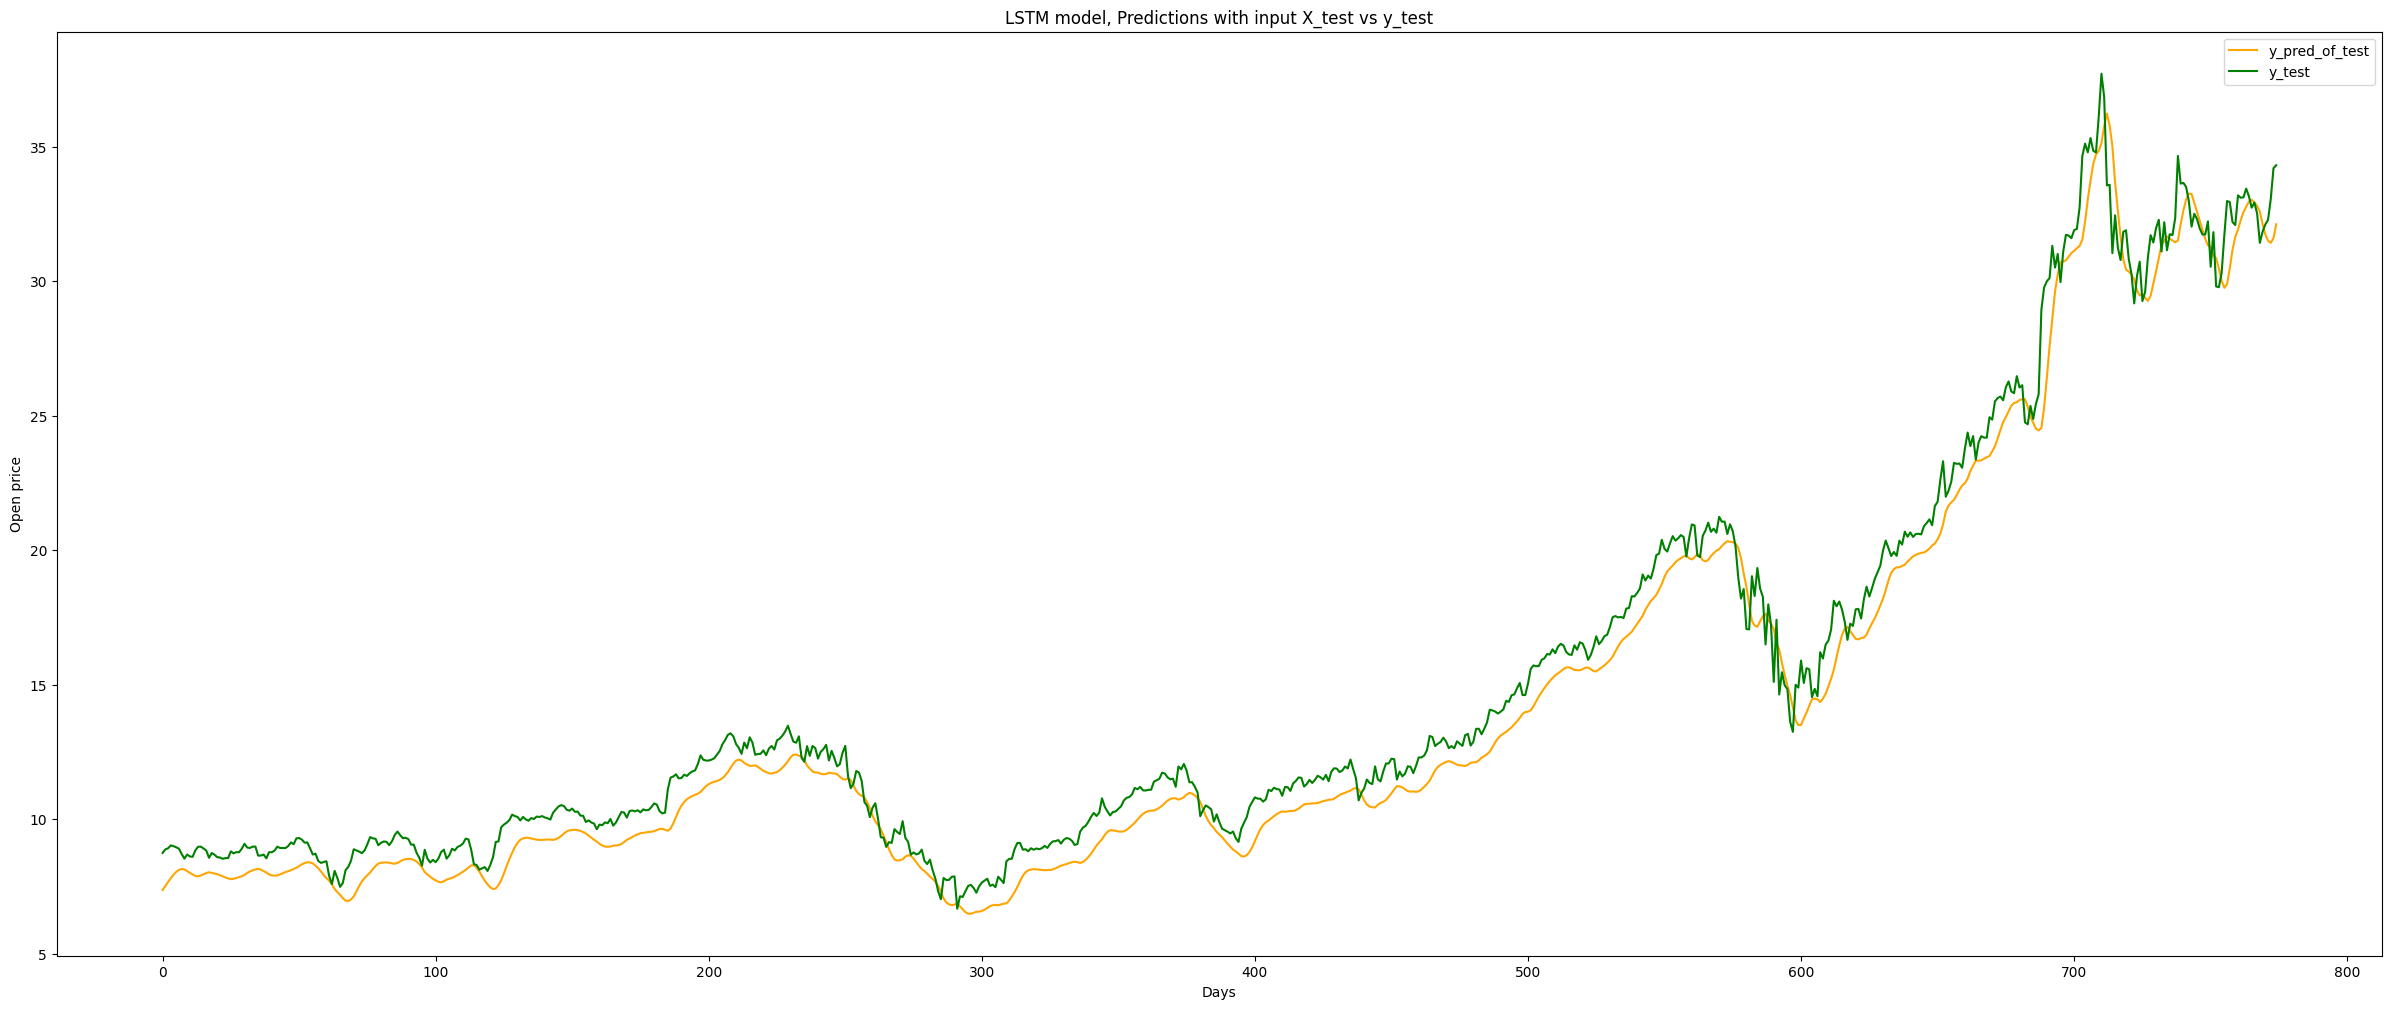

In [55]:
plt.subplots(figsize =(30,12))
plt.plot(scaler.inverse_transform(model_lstm.predict(X_test)), label = "y_pred_of_test", c = "orange" )
plt.plot(scaler.inverse_transform(y_test), label = "y_test", color = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("LSTM model, Predictions with input X_test vs y_test")
plt.legend()
plt.show()

In [56]:
data.iloc[-1]

Close     1.198125e+02
High      1.200948e+02
Low       1.176806e+02
Open      1.187806e+02
Volume    8.900420e+07
Name: 2020-12-02 00:00:00, dtype: float64

In [57]:
X_input = data.iloc[-time_step:].Open.values               # getting last 50 rows and converting to array
X_input = scaler.fit_transform(X_input.reshape(-1,1))      # converting to 2D array and scaling
X_input = np.reshape(X_input, (1,50,1))                    # reshaping : converting to 3D array
print("Shape of X_input :", X_input.shape)
X_input

Shape of X_input : (1, 50, 1)


array([[[0.32089574],
        [0.        ],
        [0.1621883 ],
        [0.48955299],
        [0.46666726],
        [0.42885542],
        [0.62039785],
        [0.38407985],
        [0.43482708],
        [0.52388035],
        [0.47015   ],
        [0.55124327],
        [0.5029852 ],
        [0.740796  ],
        [1.        ],
        [0.78756227],
        [0.67412918],
        [0.80149187],
        [0.73582136],
        [0.54875498],
        [0.57213867],
        [0.61094405],
        [0.55820879],
        [0.43980016],
        [0.51343338],
        [0.4915432 ],
        [0.35820922],
        [0.29303396],
        [0.19601957],
        [0.22338293],
        [0.44626886],
        [0.63582049],
        [0.66438484],
        [0.77303021],
        [0.52633639],
        [0.60806895],
        [0.72917259],
        [0.7202019 ],
        [0.69428789],
        [0.72568375],
        [0.67883702],
        [0.62800321],
        [0.68033208],
        [0.60757037],
        [0.4446033 ],
        [0

In [58]:
simple_RNN_prediction = scaler.inverse_transform(regressor.predict(X_input))
LSTM_prediction = scaler.inverse_transform(model_lstm.predict(X_input))
print("Simple RNN, Open price prediction for 3/18/2017      :", simple_RNN_prediction[0,0])
print("LSTM prediction, Open price prediction for 3/18/2017 :", LSTM_prediction[0,0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Simple RNN, Open price prediction for 3/18/2017      : 115.277534
LSTM prediction, Open price prediction for 3/18/2017 : 114.57882
